# Classification Linéaire avec la règle de Rosenblatt

## Import de packages

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

## Définition d'un petit dataset 'jouet'

In [ ]:
points = np.random.rand(25, 2)

In [ ]:
labels = np.array([[1] if -p[1] + p[0] + 0.25 >= 0 else [0] for p in points])

In [ ]:
colors = ['red' if l[0] == 1 else 'blue' for l in labels]

## Affichage du dataset

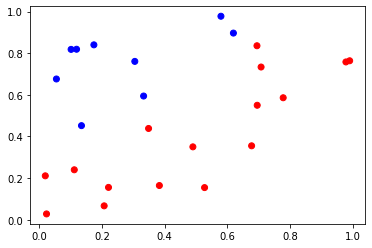

In [ ]:
plt.scatter(points[:, 0], points[:, 1], c=colors)

## Initialisation des poids du modèle linéaire au hasard (ici entre 0 et 1)

In [ ]:
W = np.random.rand(3)

In [ ]:
W

array([0.53018173, 0.73580348, 0.84360726])

## Entrainement du modèle linéaire avec la règle de Rosenblatt

In [ ]:
from operator import matmul
for _ in range(10000):
  k = np.random.randint(0, len(labels))
  Yk = labels[k]
  Xk = np.array([1, points[k][0], points[k][1]])
  signal = np.matmul(W, Xk)
  gXk = 1.0 if np.squeeze(np.matmul(W.T, Xk)) >= 0 else 0.0
  W = W + 0.01 * (Yk - gXk) * Xk

##Interrogation du modèle sur tout le reste de l'espace d'entrée

In [ ]:
predicted_labels = []
predicted_x1 = []
predicted_x2 = []
for x1 in range(0, 100):
  for x2 in range(0, 100):
    predicted_x1.append(x1/100)
    predicted_x2.append(x2/100)
    predicted_labels.append('pink' if x1/100 * W[1] + x2/100 * W[2] + W[0] >= 0 else 'lightskyblue')

## Affichage des prédictions sur le reste des entrées pour visualiser la séparation linéaire

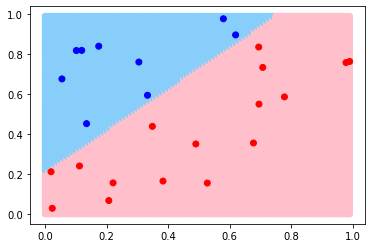

In [ ]:
plt.scatter(predicted_x1, predicted_x2, c=predicted_labels)
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

# Definition d'un PMC

In [ ]:
from typing import List

In [ ]:
class MyMLP:
  # Constructeur
  # npl : Neurons Per Layer - représentant la structure du PMC choisie par l'utilisateur 
  # (nombre d'entrées, nombre de neurones par couches cachées, nombre de sorties)
  def __init__(self, npl: List[int]):
    self.d = npl
    self.L = len(npl) - 1
    self.W = []

    # Initialisation des poids du modèles entre -1 et 1 (sauf pour les poids inutiles que l'on laissera à 0)
    for l in range(self.L + 1):
      self.W.append([])

      if l == 0:
        continue
      for i in range(npl[l - 1] + 1):
        self.W[l].append([])
        for j in range(npl[l] + 1):
          self.W[l][i].append(0.0 if j == 0 else np.random.uniform(-1.0, 1.0))
    
    # Création de l'espace mémoire pour 'stocker' plus tard les valeurs de sorties de chaque neurone
    self.X = []
    for l in range(self.L + 1):
      self.X.append([])
      for j in range(npl[l] + 1):
        self.X[l].append(1.0 if j == 0 else 0.0)

    # Création de l'espace mémoire pour 'stocker' plus tard les semi-gradient associés à chaque neurone
    self.deltas = []
    for l in range(self.L + 1):
      self.deltas.append([])
      for j in range(npl[l] + 1):
        self.deltas[l].append(0.0)

  # Propagation et mise à jour des valeurs de sorties de chaque neurone à partir des entrées d'un exemple
  def _propagate(self, inputs: List[float], is_classification: bool):
    # copie des entrées dans la 'couche d'entrée' du modèle
    for j in range(self.d[0]): 
      self.X[0][j + 1] = inputs[j]
    
    # mise à jour récursive des valeurs de sorties des neurones, couche après couche
    for l in range(1, self.L + 1):
      for j in range(1, self.d[l] + 1):
        total = 0.0
        for i in range(0, self.d[l - 1] + 1):
          total += self.W[l][i][j] * self.X[l - 1][i]
        
        if l < self.L or is_classification:
          total = np.tanh(total)
        
        self.X[l][j] = total

  # Méthode à utiliser pour interroger le modèle (inférence)
  def predict(self, inputs: List[float], is_classification: bool):
    self._propagate(inputs, is_classification)
    return self.X[self.L][1:]

  # Méthode à utiliser pour entrainer le modèle à partir d'un dataset étiqueté
  def train(self, all_samples_inputs: List[List[float]], all_samples_expected_outputs: List[List[float]],
            is_classification: bool, iteration_count: int, alpha: float):
    # Pour un certain nombre d'itération
    for it in range(iteration_count):
      # Choix d'un exemple étiqueté au hasard dans le dataset
      k = np.random.randint(0, len(all_samples_inputs))
      inputs_k = all_samples_inputs[k]
      y_k = all_samples_expected_outputs[k]

      # Mise à jour des valeurs de sorties des neurones du modèle à partir des entrées de l'exemple sélectionné
      self._propagate(inputs_k, is_classification)

      # Calcul des semi gradients des neurones de la dernière couche
      for j in range(1, self.d[self.L] + 1):
        self.deltas[self.L][j] = (self.X[self.L][j] - y_k[j - 1])
        if is_classification:
          self.deltas[self.L][j] *= (1 - self.X[self.L][j] ** 2)

      # Calcul de manière récursive des semi gradients des neurones des couches précédentes
      for l in reversed(range(1, self.L + 1)):
        for i in range(1, self.d[l - 1] + 1):
          total = 0.0
          for j in range(1, self.d[l] + 1):
            total += self.W[l][i][j] * self.deltas[l][j]
          self.deltas[l-1][i] = (1 - self.X[l-1][i] ** 2) * total

      # Correction des poids du modèle
      for l in range(1, self.L + 1):
        for i in range(0, self.d[l - 1] + 1):
          for j in range(1, self.d[l] + 1):
            self.W[l][i][j] -= alpha * self.X[l - 1][i] * self.deltas[l][j]

# Classification Linéaire avec un PMC (sans couche cachée)

In [ ]:
test_1_all_samples_inputs = [
    [0, 0],
    [0, 1],
    [1, 0]
]
test_1_all_samples_expected_outputs = [
    [1],
    [-1],
    [-1]
]

In [ ]:
test1_mlp = MyMLP([2, 1])

In [ ]:
for sample_inputs in test_1_all_samples_inputs:
  print(test1_mlp.predict(sample_inputs, True))

[0.19854860472983002]
[0.8147933384679242]
[0.611574372939876]


In [ ]:
test1_mlp.train(test_1_all_samples_inputs, test_1_all_samples_expected_outputs, True, 100000, 0.01)

In [ ]:
for sample_inputs in test_1_all_samples_inputs:
  print(test1_mlp.predict(sample_inputs, True))

[0.9548135202945885]
[-0.9716046796330355]
[-0.9715893811409624]


# Classification Non Linéaire (XOR) avec un PMC

In [ ]:
test_2_all_samples_inputs = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]
test_2_all_samples_expected_outputs = [
    [-1],
    [1],
    [1],
    [-1]
]

In [ ]:
test2_mlp = MyMLP([2, 2, 1])

In [ ]:
for sample_inputs in test_2_all_samples_inputs:
  print(test2_mlp.predict(sample_inputs, True))

[0.5660343223590687]
[-0.075010878135399]
[-0.0951304805861134]
[-0.5107276023165531]


In [ ]:
test2_mlp.train(test_2_all_samples_inputs, test_2_all_samples_expected_outputs, True, 100000, 0.01)

In [ ]:
for sample_inputs in test_2_all_samples_inputs:
  print(test2_mlp.predict(sample_inputs, True))

[-0.9792184154917847]
[0.9752548017156218]
[0.9743861713999539]
[-0.9817632335679124]


# Régression Linéaire avec un PMC (sans couche cachée)

In [ ]:
test_3_all_samples_inputs = [
    [0, 0],
    [0, 1],
    [1, 0]
]
test_3_all_samples_expected_outputs = [
    [42],
    [51],
    [19]
]

In [ ]:
test3_mlp = MyMLP([2, 1])

In [ ]:
for sample_inputs in test_3_all_samples_inputs:
  print(test3_mlp.predict(sample_inputs, False))

[-0.4628262939221668]
[-0.7055432287378138]
[0.3956549819643127]


In [ ]:
test3_mlp.train(test_3_all_samples_inputs, test_3_all_samples_expected_outputs, False, 100000, 0.01)

In [ ]:
for sample_inputs in test_3_all_samples_inputs:
  print(test3_mlp.predict(sample_inputs, False))

[41.999999999999645]
[51.000000000000085]
[19.000000000000178]


# Régression Non Linéaire avec un PMC

In [ ]:
test_4_all_samples_inputs = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
]
test_4_all_samples_expected_outputs = [
    [42],
    [51],
    [19],
    [5],
]

In [ ]:
test4_mlp = MyMLP([2, 5, 1])

In [ ]:
for sample_inputs in test_4_all_samples_inputs:
  print(test4_mlp.predict(sample_inputs, False))

[0.3958294010127158]
[-0.13812786254329584]
[0.8295645112511555]
[0.4765698830536045]


In [ ]:
test4_mlp.train(test_4_all_samples_inputs, test_4_all_samples_expected_outputs, False, 100000, 0.01)

In [ ]:
for sample_inputs in test_4_all_samples_inputs:
  print(test4_mlp.predict(sample_inputs, False))

[41.999999999999744]
[50.99999999999999]
[18.999999999999993]
[4.9999999999999964]
